In [2]:
import psycopg2 as pg
import pandas as pd

# We are also going to do some basic viz
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.metrics import roc_curve , roc_auc_score
from sklearn.model_selection import GridSearchCV

#Import all the models that I will use
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
connection_args = {
    'host': 'localhost',  # We are connecting to our _local_ version of psql
    'dbname': 'song_classifier',    # DB that we are connecting to
}
connection = pg.connect(**connection_args)

In [4]:
query = "SELECT * FROM songs_of_the_60s\
        UNION \
        SELECT * FROM songs_of_the_70s\
        UNION\
        SELECT * FROM songs_of_the_80s\
        UNION\
        SELECT * FROM songs_of_the_90s\
        UNION\
        SELECT * FROM songs_of_the_00s\
        UNION\
        SELECT * FROM songs_of_the_10s;"

songs_df = pd.read_sql(query, connection)
songs_df.shape

(41106, 20)

In [5]:
songs_df.sort_values('decade')

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
25421,One Has My Name (The Other Has My Heart),Barry Young,spotify:track:3Vd7lnnD4xihfGIgqNDo9B,0.514,0.403,9,-14.822,1,0.030,0.770,0.000,0.232,0.653,112.532,155627,4,21.854,7,1,1960
7562,Daughter,The Blenders,spotify:track:7lKJR80q1kJJXZupkR4ahk,0.705,0.658,7,-9.072,1,0.058,0.819,0.000,0.096,0.931,126.008,130400,4,28.500,8,1,1960
36320,"To Be Young, Gifted And Black",Nina Simone,spotify:track:67RKpDruBXMJgAmhJAivXr,0.563,0.341,0,-8.445,1,0.031,0.625,0.000,0.137,0.712,79.148,169840,3,61.403,8,1,1960
29899,Selfish One,Jackie Ross,spotify:track:6tVN4XTLCTPCOx2Xk7PHf0,0.619,0.575,7,-7.620,1,0.039,0.551,0.000,0.092,0.758,116.737,200200,4,19.461,9,1,1960
17880,Jazz Club,Luis Bacalov,spotify:track:3t23NcvlpgLkljXdfZHXNJ,0.552,0.101,8,-20.881,1,0.038,0.866,0.900,0.121,0.266,63.933,262400,4,25.077,11,0,1960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32932,Sweater Weather,The Neighbourhood,spotify:track:2QjOHCTQ1Jl3zawyYOpxh6,0.612,0.807,10,-2.810,1,0.034,0.050,0.018,0.101,0.398,124.053,240400,4,91.206,7,1,2010
13097,Habits (Stay High),Tove Lo,spotify:track:14OxJlLdcHNpgsm4DRwDOB,0.733,0.650,5,-3.539,1,0.032,0.070,0.000,0.083,0.348,110.003,209160,4,42.023,9,1,2010
32935,Sweet Annie,Zac Brown Band,spotify:track:2PEkXkHKvk4bnC1TgTDCDM,0.635,0.434,6,-7.986,1,0.030,0.171,0.000,0.106,0.171,139.976,278693,4,23.110,12,1,2010
13114,Hail To The King,Avenged Sevenfold,spotify:track:5anCkDvJ17aznvK5TED5uo,0.580,0.916,3,-4.358,0,0.039,0.000,0.026,0.126,0.683,118.004,305907,4,31.695,14,1,2010


In [6]:
songs_df['artist'].value_counts()

Traditional                                     207
Harry Belafonte                                 140
P. Susheela                                     130
Ennio Morricone                                 128
Jerry Goldsmith                                 124
                                               ... 
Nargaroth                                         1
Protohype                                         1
Choirboys                                         1
Tiesto & Dzeko Featuring Preme & Post Malone      1
Laura Lee                                         1
Name: artist, Length: 11904, dtype: int64

In [7]:
songs_df[songs_df['artist']=='Traditional']

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
5,"""Joseph, lieber Joseph mein""",Traditional,spotify:track:7u5NOkNdQ2Bywcx9jSTq0S,0.282,0.060,7,-26.589,1,0.042,0.993,0.849,0.107,0.201,76.620,110173,4,32.828,7,0,1960
36,'Tis The Last Rose Of Summer,Traditional,spotify:track:7LqTWAztzC4lY3osmgFGxp,0.179,0.017,1,-24.118,1,0.040,0.992,0.941,0.125,0.040,68.059,105107,3,55.113,4,0,1960
986,Abbots Bromley Horn Dance,Traditional,spotify:track:1WqoGoeoEhWYcPyFODNe3S,0.311,0.002,1,-35.298,0,0.044,0.930,0.001,0.099,0.822,133.417,109840,3,33.114,6,0,1970
1056,Aclarida Nit de Nadal,Traditional,spotify:track:7nVUigmHaAxjwlk3iyFwne,0.244,0.044,0,-17.074,1,0.038,0.990,0.000,0.180,0.182,97.715,118053,1,34.267,9,0,1960
1102,Adeste fideles (O Come All Ye Faithful),Traditional,spotify:track:5yc8WP1ZhiJJPdGIjijk90,0.248,0.112,1,-18.399,1,0.041,0.978,0.004,0.056,0.151,134.596,178480,1,69.689,9,0,1970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38970,When I First Came To This Land,Traditional,spotify:track:55q5GaqvdcCRKmMYbEqm4R,0.338,0.079,2,-22.329,1,0.055,0.995,0.000,0.092,0.249,167.640,180627,5,47.231,10,0,1960
39022,When Johnny Comes Marching Home,Traditional,spotify:track:1f7Iy4msXQBSSfgDMH8bsE,0.580,0.337,7,-9.406,0,0.038,0.792,0.000,0.215,0.421,106.694,209747,4,28.118,10,0,1960
39764,Woll'n Heimgehn,Traditional,spotify:track:7JetpHtW997IGJ3f8fx5x3,0.287,0.032,5,-23.385,1,0.034,0.827,0.000,0.099,0.146,69.651,64440,3,15.075,3,0,1960
40008,Y Deryn Pur,Traditional,spotify:track:1zK6Q8j4pMagtBatNkqL0d,0.349,0.030,5,-23.825,1,0.059,0.985,0.000,0.089,0.068,108.148,170533,5,27.716,8,0,1960


In [8]:
songs_df['target'].mean()

0.5

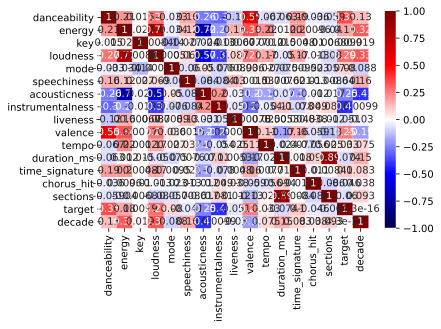

In [9]:
sns.heatmap(songs_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [ ]:
sns.pairplot(songs_df,hue='target');

### Run a kNN

In [10]:

#features = ['danceability', 'loudness', 'duration_ms','decade']

X = songs_df.drop(columns=['target','uri','artist','track'])
y = songs_df['target'].values

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.3)

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [17]:
ks = list(range(1,51))

param_grid = dict(n_neighbors = ks)

nn = KNeighborsClassifier()

grid = GridSearchCV(nn, param_grid, cv = 5, scoring = 'accuracy',verbose=1)
grid.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 10.3min finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='accuracy', verbose=1)

In [20]:
grid.best_params_

{'n_neighbors': 18}

In [25]:
nn = KNeighborsClassifier(n_neighbors=18,n_jobs=-1)

nn_classifier = nn.fit(X_train_scaled,y_train)

print("kNN confusion matrix: \n\n", confusion_matrix(y_test, nn.predict(X_test_scaled)))

kNN confusion matrix: 

 [[2657 1455]
 [ 522 3588]]


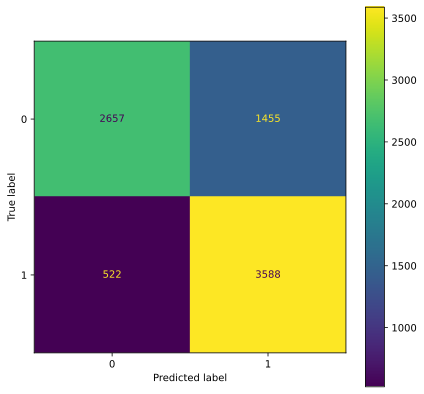

In [26]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(nn_classifier,X_test_scaled, y_test, ax=ax)

In [27]:
nn.score(X_val_scaled,y_val)

0.7601864990877762

### Logistic  Regression

In [28]:
lr = LogisticRegression(penalty='none')

lr.fit(X_train_scaled, y_train)

y_preds = lr.predict(X_val_scaled)

print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.79      0.66      0.72      4930
           1       0.71      0.83      0.76      4936

    accuracy                           0.74      9866
   macro avg       0.75      0.74      0.74      9866
weighted avg       0.75      0.74      0.74      9866



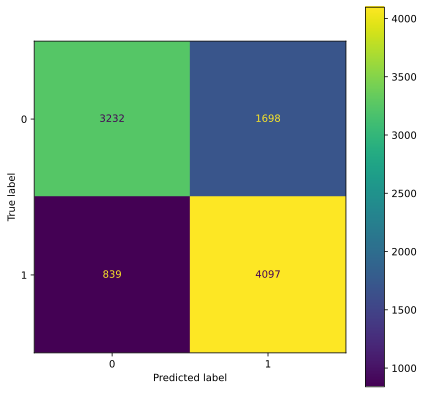

In [29]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(lr, X_val_scaled, y_val, ax=ax);

In [30]:
lr.score(X_val_scaled,y_val)

0.7428542469085749

### GaussianNB

In [31]:
gb = GaussianNB()
gb.fit(X_train_scaled,y_train)
y_pred_gb = gb.predict(X_val_scaled) 

In [32]:
print("GaussianNB confusion matrix: \n\n", confusion_matrix(y_val, y_pred_gb))

GaussianNB confusion matrix: 

 [[2677 2253]
 [ 615 4321]]


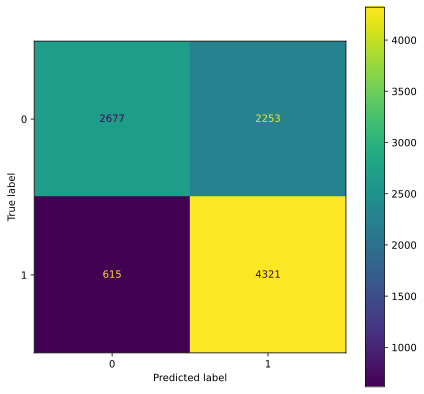

In [33]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(gb, X_val_scaled, y_val, ax=ax);

#### SVC Model

In [34]:
svc = SVC(probability=True)
svc.fit(X_train_scaled,y_train)
y_pred_svc = svc.predict(X_val_scaled)
svc.score(X_val_scaled,y_val)

0.7918102574498277

In [35]:
print("SVC confusion matrix: \n\n", confusion_matrix(y_val, y_pred_svc))

SVC confusion matrix: 

 [[3444 1486]
 [ 568 4368]]


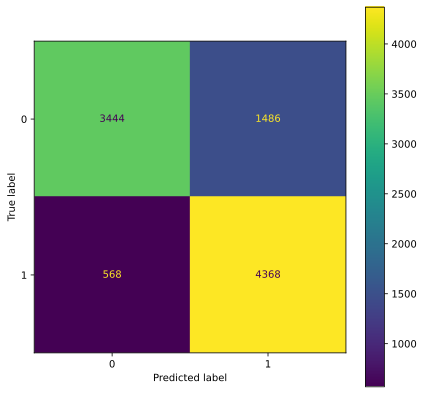

In [36]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(svc, X_val_scaled, y_val, ax=ax);

### DecisionTree

In [37]:
dcf = DecisionTreeClassifier(random_state=0)
dcf.fit(X_train,y_train)
y_pred = dcf.predict(X_val)
#dcf.score(X_train,y_train)
dcf.score(X_val,y_val)

0.7177174133387391

### RandomForest Classifier

In [38]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_val)
rfc.score(X_val,y_val)

0.8018447192377863

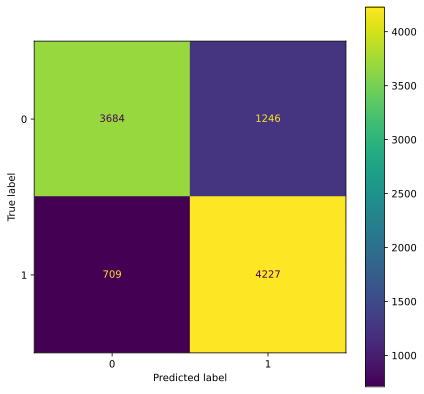

In [39]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(rfc, X_val, y_val, ax=ax);

### Plot ROC

In [40]:


fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_val, nn.predict_proba(X_val_scaled)[:,1])
fpr_log, tpr_log, thresholds_log = roc_curve(y_val, lr.predict_proba(X_val_scaled)[:,1])
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_val, gb.predict_proba(X_val_scaled)[:,1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_val, rfc.predict_proba(X_val)[:,1])
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_val, svc.predict_proba(X_val_scaled)[:,1])
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_val, dcf.predict_proba(X_val)[:,1])


KNN ROC AUC score =  0.5
Logit ROC AUC score =  0.5001215953307393
Naive Bayes ROC AUC score =  0.5
Random Forest ROC AUC score =  0.877641754712337
Support Vector Machines ROC AUC score =  0.5
Decision Tree ROC AUC score =  0.7167883211678833


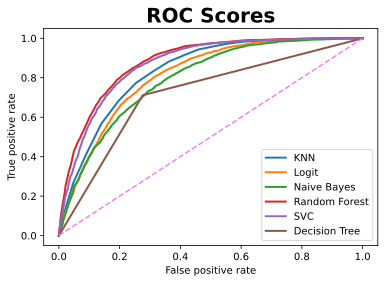

In [43]:
plt.plot(fpr_knn, tpr_knn,lw=2)
plt.plot(fpr_log, tpr_log,lw=2)
plt.plot(fpr_nb, tpr_nb,lw=2)
plt.plot(fpr_rf, tpr_rf,lw=2)
plt.plot(fpr_svc, tpr_svc,lw=2)
plt.plot(fpr_dt, tpr_dt,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Scores', fontweight='bold', fontsize=20);
plt.legend(['KNN', 'Logit', 'Naive Bayes', 'Random Forest','SVC', 'Decision Tree'])
print('KNN ROC AUC score = ', roc_auc_score(y_test, nn.predict_proba(X_test)[:,1]))
print('Logit ROC AUC score = ', roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))
print('Naive Bayes ROC AUC score = ', roc_auc_score(y_test, gb.predict_proba(X_test)[:,1]))
print('Random Forest ROC AUC score = ', roc_auc_score(y_test, rfc.predict_proba(X_test)[:,1]))
print('Support Vector Machines ROC AUC score = ', roc_auc_score(y_test, svc.predict_proba(X_test)[:,1]))
print('Decision Tree ROC AUC score = ', roc_auc_score(y_test, dcf.predict_proba(X_test)[:,1]))

### Add Artist the the models using OHE

In [34]:
len(songs_df['artist'].unique())

11904

There are 11904 Unique artist in the data I need to figure out which ones to encode

In [35]:
from sklearn.preprocessing import OneHotEncoder

In [36]:
songs_df['artist'].value_counts()

Traditional         207
Harry Belafonte     140
P. Susheela         130
Ennio Morricone     128
Jerry Goldsmith     124
                   ... 
David Geddes          1
Bulldog               1
The Valentinos        1
Toro y Moi            1
Gilberto Monroig      1
Name: artist, Length: 11904, dtype: int64

In [37]:
songs_tradit = songs_df[songs_df['artist'] == 'Taylor Swift']

In [38]:
songs_tradit[songs_tradit['target']==1]

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
229,...Ready For It?,Taylor Swift,spotify:track:2yLa0QULdQr0qAIvVwN6B5,0.613,0.764,2,-6.509,1,0.136,0.053,0.000,0.197,0.417,160.015,208187,4,45.952,8,1,2010
351,22,Taylor Swift,spotify:track:3bIxTsfeNMO7Nt2J3EUKrA,0.658,0.729,7,-6.561,1,0.038,0.002,0.001,0.075,0.668,104.007,230133,4,23.862,9,1,2010
3024,Back To December,Taylor Swift,spotify:track:3DrjZArsPsoqbLzUZZV1Id,0.529,0.670,2,-4.663,1,0.030,0.117,0.000,0.334,0.286,141.893,293027,4,41.567,14,1,2010
3561,Begin Again,Taylor Swift,spotify:track:0L4YCNRfXAoTvdpWeH2RGj,0.530,0.526,7,-8.349,1,0.026,0.199,0.000,0.232,0.323,79.025,237613,4,32.830,13,1,2010
4057,Blank Space,Taylor Swift,spotify:track:1kHEuJRasudLhjvnbfc4yS,0.760,0.703,5,-5.412,1,0.054,0.103,0.000,0.091,0.570,95.997,231827,4,36.563,11,1,2010
5136,Call It What You Want,Taylor Swift,spotify:track:1GwMQaZz6Au3QLDbjbMdme,0.598,0.504,9,-9.874,1,0.073,0.186,0.000,0.340,0.252,163.954,203507,4,31.720,11,1,2010
5828,Change,Taylor Swift,spotify:track:1yACRKAwlXWhXXFUSkvzhD,0.541,0.770,5,-4.170,1,0.035,0.004,0.000,0.117,0.215,96.013,280240,4,47.689,12,1,2000
6109,Christmas Tree Farm,Taylor Swift,spotify:track:2mvabkN1i2gLnGAPUVdwek,0.598,0.680,7,-4.505,1,0.033,0.060,0.000,0.324,0.437,134.002,228027,4,56.665,9,1,2010
6981,Crazier,Taylor Swift,spotify:track:5vyxXfD5gLlyPxGZMEjtmd,0.452,0.544,4,-5.423,1,0.028,0.063,0.000,0.104,0.158,133.042,191947,3,30.924,9,1,2000
7845,Delicate,Taylor Swift,spotify:track:6NFyWDv5CjfwuzoCkw47Xf,0.750,0.404,9,-10.178,0,0.068,0.216,0.000,0.091,0.050,95.045,232253,4,23.566,12,1,2010


#### All of the Traditonal artist are "flop" songs so I will not use it as a encoded value

In [39]:
top_forty = songs_df['artist'].value_counts().iloc[1:41]
mask = songs_df['artist'].isin(top_forty.index)

In [40]:
import numpy as np 
#np.array(songs_df['artist'][mask])

In [41]:
songs_df.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
0,"""Cherry Cherry"" from Hot August Night",Neil Diamond,spotify:track:18ocy9Be9SxWEEnOLGDfkS,0.341,0.948,9,-5.081,1,0.136,0.101,0.001,0.874,0.632,171.578,443320,4,53.790,16,1,1970
1,"""Come, Sleep...""",Louise Bogan,spotify:track:4xKA7wp7HGw2DFKXqDZ1ME,0.734,0.069,3,-24.330,1,0.917,0.611,0.000,0.106,0.319,108.734,78472,5,31.287,4,0,1960
2,"""I'll Be Back"" / Police Station & Escape",Brad Fiedel,spotify:track:1f0PV8tI4rVILknKlulMWL,0.201,0.391,7,-16.067,1,0.048,0.889,0.864,0.111,0.181,59.801,226310,4,38.292,10,0,1980
3,"""Is This My Fate,"" He Asked Them",Story Of The Year,spotify:track:0GsdISsN8uyvTzz7mPcj5o,0.254,0.970,8,-4.635,1,0.079,0.000,0.006,0.141,0.166,99.963,300520,4,55.200,13,0,2010
4,"""Jerry"" To The Rescue",Pino Donaggio,spotify:track:2TpEGnzSyxjUDwxtYMrf8C,0.215,0.242,0,-15.141,0,0.040,0.584,0.936,0.146,0.061,116.234,143520,4,25.609,9,0,1970


In [42]:
X = songs_df.drop(columns=['target','uri','track','artist'])
y = songs_df['target'].values

In [43]:
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.3)

In [44]:
X_train.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,decade
3158,0.495,0.553,11,-13.477,1,0.030,0.001,0.002,0.377,0.962,115.799,213267,4,25.442,11,1970
16227,0.653,0.760,7,-3.774,1,0.028,0.053,0.000,0.505,0.590,91.845,206147,4,28.113,12,2000
25094,0.770,0.865,3,-7.531,0,0.069,0.062,0.003,0.352,0.711,126.056,512733,4,70.889,19,1990
25280,0.570,0.462,11,-10.483,1,0.028,0.740,0.000,0.104,0.545,102.300,181893,4,41.670,6,1970
31660,0.613,0.458,5,-12.216,1,0.033,0.818,0.143,0.112,0.318,102.700,187213,4,83.169,6,1970


In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [46]:
lr = LogisticRegression(penalty='none')

lr.fit(X_train_scaled, y_train)

y_preds = lr.predict(X_val_scaled)

print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.79      0.66      0.72      4964
           1       0.71      0.83      0.76      4902

    accuracy                           0.74      9866
   macro avg       0.75      0.74      0.74      9866
weighted avg       0.75      0.74      0.74      9866



In [47]:
print('Logistic Regression train score: {:.3f}'.format(lr.score(X_train_scaled,y_train)))
print('Logistic Regression test score: {:.3f}'.format(lr.score(X_val_scaled,y_val)))

Logistic Regression train score: 0.741
Logistic Regression test score: 0.743


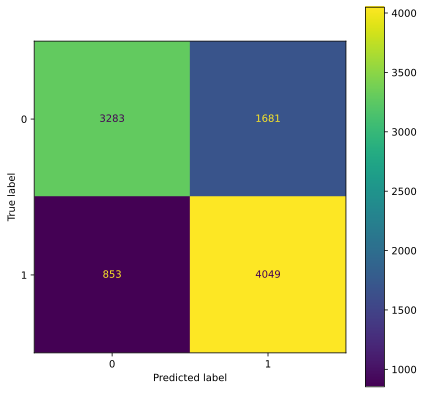

In [48]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(lr, X_val_scaled, y_val, ax=ax);

In [49]:
gb = GaussianNB()
gb.fit(X_train_scaled,y_train)
y_pred_gb = gb.predict(X_val_scaled) 

In [50]:
print('Naive Bayes train score: {:.3f}'.format(gb.score(X_train_scaled,y_train)))
print('Naive Bayes test score: {:.3f}'.format(gb.score(X_val_scaled,y_val)))

Naive Bayes train score: 0.710
Naive Bayes test score: 0.715


#### By adding all of the artist as encoded variables I am overfitting I will scale back and encode only the top 100

In [43]:
artist_dummies = pd.get_dummies(songs_df['artist'][mask])

In [44]:
songs_df = pd.concat([songs_df, artist_dummies], axis=1)

In [45]:
songs_df.shape

(41106, 120)

In [46]:
X = songs_df.drop(columns=['target','uri','track','artist'])
y = songs_df['target'].values

In [47]:
X.fillna(0,inplace=True)

In [48]:
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.3)

In [49]:
X.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,Tim McGraw,Tito Puente,Tito Rodriguez,Toby Keith,Ton Steine Scherben,Vicente Fernández,Victor Jara,Vladimir Cosma,Wire,kalapana
0,0.341,0.948,9,-5.081,1,0.136,0.101,0.001,0.874,0.632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.734,0.069,3,-24.330,1,0.917,0.611,0.000,0.106,0.319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.201,0.391,7,-16.067,1,0.048,0.889,0.864,0.111,0.181,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.254,0.970,8,-4.635,1,0.079,0.000,0.006,0.141,0.166,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.215,0.242,0,-15.141,0,0.040,0.584,0.936,0.146,0.061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [51]:
lr = LogisticRegression(penalty='none')

lr.fit(X_train_scaled, y_train)

y_preds = lr.predict(X_val_scaled)

print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.83      0.71      0.77      4930
           1       0.75      0.85      0.80      4936

    accuracy                           0.78      9866
   macro avg       0.79      0.78      0.78      9866
weighted avg       0.79      0.78      0.78      9866



In [52]:
print('Linear Regression train score: {:.3f}'.format(lr.score(X_train_scaled,y_train)))
print('Linear Regression test score: {:.3f}'.format(lr.score(X_val_scaled,y_val)))

Linear Regression train score: 0.788
Linear Regression test score: 0.782


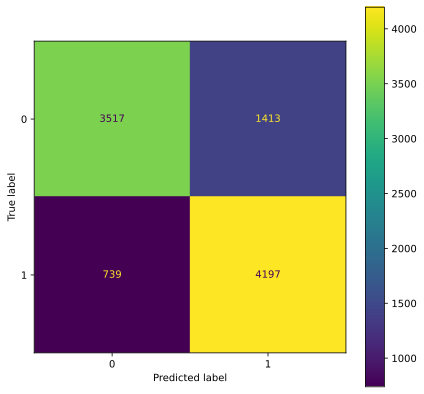

In [53]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(lr, X_val_scaled, y_val, ax=ax);

### GB with top 40 artist

In [54]:
gb = GaussianNB()
gb.fit(X_train_scaled,y_train)
y_pred_gb = gb.predict(X_val_scaled) 

In [55]:
print('Naive Bayes train score: {:.3f}'.format(gb.score(X_train_scaled,y_train)))
print('Naive Bayes test score: {:.3f}'.format(gb.score(X_val_scaled,y_val)))

Naive Bayes train score: 0.593
Naive Bayes test score: 0.593


In [56]:
print(classification_report(y_val, y_pred_gb))

              precision    recall  f1-score   support

           0       1.00      0.19      0.31      4930
           1       0.55      1.00      0.71      4936

    accuracy                           0.59      9866
   macro avg       0.78      0.59      0.51      9866
weighted avg       0.78      0.59      0.51      9866



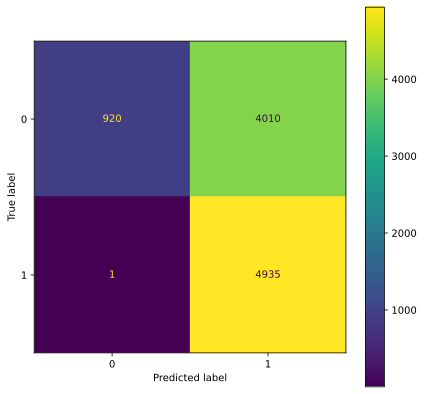

In [57]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(gb, X_val_scaled, y_val, ax=ax);

In [58]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train_scaled,y_train)
y_pred_svc = svc.predict(X_val_scaled)

print('SVC train score: {:.3f}'.format(svc.score(X_train_scaled,y_train)))
print('SVC test score: {:.3f}'.format(svc.score(X_val_scaled,y_val)))

SVC train score: 0.809
SVC test score: 0.805


              precision    recall  f1-score   support

           0       0.89      0.70      0.78      4930
           1       0.75      0.92      0.82      4936

    accuracy                           0.81      9866
   macro avg       0.82      0.81      0.80      9866
weighted avg       0.82      0.81      0.80      9866



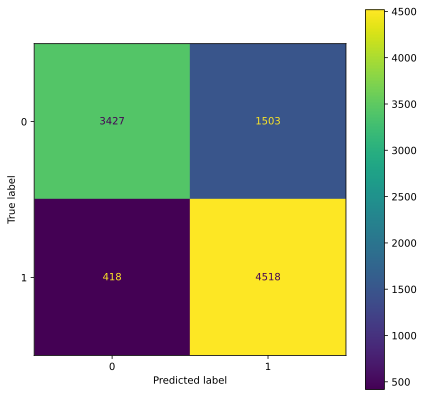

In [59]:
print(classification_report(y_val, y_pred_svc))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(svc, X_val_scaled, y_val, ax=ax);

### Decision Tree W/ top 40

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

dcf = DecisionTreeClassifier(random_state=0)
dcf.fit(X_train,y_train)
y_pred_dcf = dcf.predict(X_val)


print('DCF train score: {:.3f}'.format(dcf.score(X_train,y_train)))
print('DCF test score: {:.3f}'.format(dcf.score(X_val,y_val)))

DCF train score: 1.000
DCF test score: 0.716


              precision    recall  f1-score   support

           0       0.71      0.72      0.72      4930
           1       0.72      0.71      0.72      4936

    accuracy                           0.72      9866
   macro avg       0.72      0.72      0.72      9866
weighted avg       0.72      0.72      0.72      9866



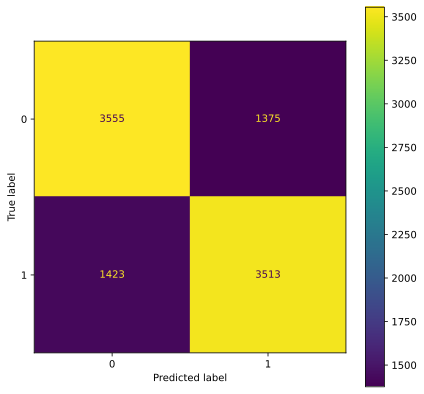

In [61]:
print(classification_report(y_val, y_pred_dcf))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(dcf, X_val, y_val, ax=ax);

####  Random Forest w/ top 40

In [62]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_val)
rfc.score(X_val,y_val)

0.8072167038313399

In [63]:
print('Random Forest train score: {:.3f}'.format(rfc.score(X_train,y_train)))
print('Random Forest test score: {:.3f}'.format(rfc.score(X_val,y_val)))

Random Forest train score: 1.000
Random Forest test score: 0.807


#### kNN w/ top 40

In [ ]:
acc = []
ks = range(1,151)
for i,k in enumerate(ks):
    nn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    nn.fit(X_train_scaled,y_train)
    y_pred = nn.predict(X_val_scaled)
    acc.append((accuracy_score(y_val, y_pred),k))
max(acc)

In [ ]:
nn = KNeighborsClassifier(n_neighbors=12,n_jobs=-1)
nn_classifier = nn.fit(X_train_scaled,y_train)
y_pred_nn = nn.predict(X_val_scaled)
print('kNN train score: {:.3f}'.format(nn.score(X_train_scaled,y_train)))
print('kNN test score: {:.3f}'.format(nn.score(X_val_scaled,y_val)))

In [ ]:
print(classification_report(y_val, y_pred_nn))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(nn, X_val_scaled, y_val, ax=ax);

## Top 100 Artist

In [4]:
top_100 = songs_df['artist'].value_counts().iloc[1:101]
mask = songs_df['artist'].isin(top_100.index)

In [5]:
artist_dummies = pd.get_dummies(songs_df['artist'][mask])

In [6]:
songs_df = pd.concat([songs_df, artist_dummies], axis=1)

In [7]:
songs_df.columns

Index(['track', 'artist', 'uri', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness',
       ...
       'Tito Puente', 'Tito Rodriguez', 'Toby Keith', 'Ton Steine Scherben',
       'Vicente Fernández', 'Victor Jara', 'Vladimir Cosma', 'Wire',
       'YELLOW MAGIC ORCHESTRA', 'kalapana'],
      dtype='object', length=120)

In [8]:
songs_df.columns

Index(['track', 'artist', 'uri', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness',
       ...
       'Tito Puente', 'Tito Rodriguez', 'Toby Keith', 'Ton Steine Scherben',
       'Vicente Fernández', 'Victor Jara', 'Vladimir Cosma', 'Wire',
       'YELLOW MAGIC ORCHESTRA', 'kalapana'],
      dtype='object', length=120)

In [9]:
X = songs_df.drop(columns=['target','uri','track','artist'])
y = songs_df['target'].values

In [10]:
X.fillna(0,inplace=True)

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.3)

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#### Logistic Regression w/ top 100 artist

In [13]:
lr = LogisticRegression(penalty='none')

lr.fit(X_train_scaled, y_train)

y_preds = lr.predict(X_val_scaled)

print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.84      0.71      0.77      4921
           1       0.75      0.87      0.80      4945

    accuracy                           0.79      9866
   macro avg       0.80      0.79      0.79      9866
weighted avg       0.80      0.79      0.79      9866



In [14]:
print('Logistic Regression train score: {:.3f}'.format(lr.score(X_train_scaled,y_train)))
print('Logistic Regression test score: {:.3f}'.format(lr.score(X_val_scaled,y_val)))

Linear Regression train score: 0.785
Linear Regression test score: 0.788


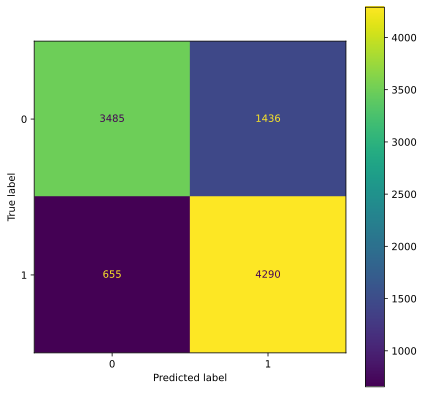

In [16]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(lr, X_val_scaled, y_val, ax=ax);

#### GaussianNB W/ top 100 artist

In [17]:
gb = GaussianNB()
gb.fit(X_train_scaled,y_train)
y_pred_gb = gb.predict(X_val_scaled)

print('Naive Bayes train score: {:.3f}'.format(gb.score(X_train_scaled,y_train)))
print('Naive Bayes test score: {:.3f}'.format(gb.score(X_val_scaled,y_val)))

print(classification_report(y_val, y_pred_gb))


Naive Bayes train score: 0.592
Naive Bayes test score: 0.593
              precision    recall  f1-score   support

           0       1.00      0.19      0.31      4921
           1       0.55      1.00      0.71      4945

    accuracy                           0.59      9866
   macro avg       0.77      0.59      0.51      9866
weighted avg       0.77      0.59      0.51      9866



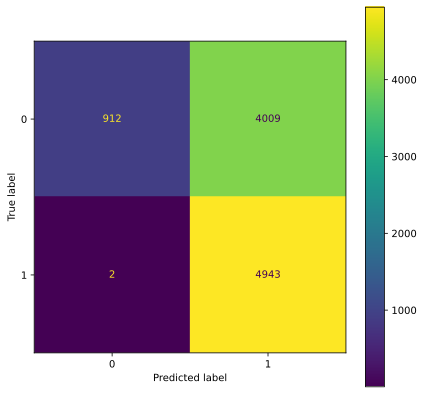

In [18]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(gb, X_val_scaled, y_val, ax=ax);

### scv w/ top 100 artist

In [19]:
svc = SVC()
svc.fit(X_train_scaled,y_train)
y_pred_svc = svc.predict(X_val_scaled)

print('SVC train score: {:.3f}'.format(svc.score(X_train_scaled,y_train)))
print('SVC test score: {:.3f}'.format(svc.score(X_val_scaled,y_val)))

SVC train score: 0.809
SVC test score: 0.810


In [20]:
print(classification_report(y_val, y_pred_svc))

              precision    recall  f1-score   support

           0       0.90      0.69      0.78      4921
           1       0.75      0.93      0.83      4945

    accuracy                           0.81      9866
   macro avg       0.83      0.81      0.81      9866
weighted avg       0.83      0.81      0.81      9866



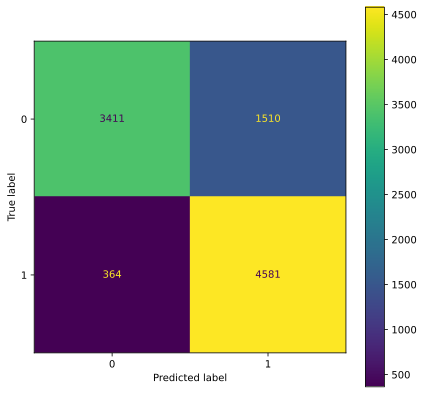

In [21]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(svc, X_val_scaled, y_val, ax=ax);

### Decision Tree W/ top 100

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

dcf = DecisionTreeClassifier(random_state=0)
dcf.fit(X_train,y_train)
y_pred_dcf = dcf.predict(X_val)


print('DCF train score: {:.3f}'.format(dcf.score(X_train,y_train)))
print('DCF test score: {:.3f}'.format(dcf.score(X_val,y_val)))

DCF train score: 1.000
DCF test score: 0.726


              precision    recall  f1-score   support

           0       0.72      0.73      0.73      4921
           1       0.73      0.72      0.73      4945

    accuracy                           0.73      9866
   macro avg       0.73      0.73      0.73      9866
weighted avg       0.73      0.73      0.73      9866



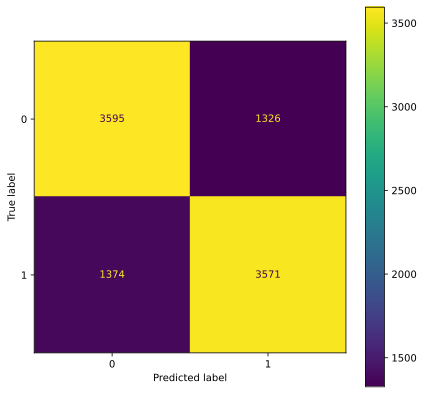

In [23]:
print(classification_report(y_val, y_pred_dcf))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(dcf, X_val, y_val, ax=ax);

### Random Forest classifier

In [43]:
rfc = RandomForestClassifier(random_state=0,min_samples_leaf=5)
rfc.fit(X_train_scaled,y_train)
y_pred = rfc.predict(X_val_scaled)

print('Random Forest train score: {:.3f}'.format(rfc.score(X_train_scaled,y_train)))
print('Random Forest test score: {:.3f}'.format(rfc.score(X_val_scaled,y_val)))

Random Forest train score: 0.831
Random Forest test score: 0.794


### kNN model w/ top 100

In [44]:
ks = list(range(1,51))

param_grid = dict(n_neighbors = ks)

nn = KNeighborsClassifier()

grid = GridSearchCV(nn, param_grid, cv = 5, scoring = 'accuracy',verbose=1)
grid.fit(X_train_scaled,y_train)

grid.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  9.6min finished


{'n_neighbors': 18}

In [35]:
nn = KNeighborsClassifier(n_neighbors=16,n_jobs=-1)
nn_classifier = nn.fit(X_train_scaled,y_train)
y_pred_nn = nn.predict(X_val_scaled)
print('kNN train score: {:.3f}'.format(nn.score(X_train_scaled,y_train)))
print('kNN test score: {:.3f}'.format(nn.score(X_val_scaled,y_val)))

kNN train score: 0.822
kNN test score: 0.800


              precision    recall  f1-score   support

           0       0.88      0.69      0.78      4921
           1       0.75      0.91      0.82      4945

    accuracy                           0.80      9866
   macro avg       0.82      0.80      0.80      9866
weighted avg       0.82      0.80      0.80      9866



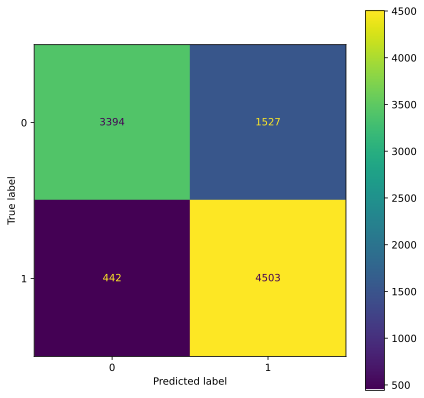

In [36]:
print(classification_report(y_val, y_pred_nn))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(nn, X_val_scaled, y_val, ax=ax);

#### Ensemble Model w/ "hard" voting

In [40]:
# Load pre-trained/tuned models

model_names = ["lr", "gb", "nn", "svc", "rfc"]

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [44]:
for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} score: {curr_model.score(X_val_scaled, y_val)}')

lr score: 0.788060004054328
gb score: 0.5934522602878572
nn score: 0.8004257044394891
svc score: 0.8100547334279343
rfc score: 0.7939387796472734


In [54]:
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
                             
                              

voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='hard', #<-- sklearn calls this hard voting
                                    n_jobs=-1)
voting_classifer.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(penalty='none')),
                             ('gb', GaussianNB()),
                             ('nn',
                              KNeighborsClassifier(n_jobs=-1, n_neighbors=16)),
                             ('svc', SVC()),
                             ('rfc',
                              RandomForestClassifier(min_samples_leaf=5,
                                                     random_state=0))],
                 n_jobs=-1)

In [55]:
y_pred = voting_classifer.predict(X_val_scaled)
accuracy_score(y_val, y_pred)

0.809953375228056

#### Ensemble Model w/ "soft" voting

In [ ]:
model_names = ["lr", "gb", "nn", "rfc"]

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))
# create voting classifier
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='soft', #<-- sklearn calls this soft voting
                                    n_jobs=-1)
voting_classifer.fit(X_train_scaled, y_train)

In [59]:
# y_pred = voting_classifer.predict(X_test)
# accuracy_score(y_test, y_pred)